# Yammer
Yammer is a social network for communicating with coworkers. Individuals share documents, updates, and ideas by posting them in groups, it’s like Slack. Yammer is free to use indefinitely, but companies must pay license fees if they want access to administrative controls, including integration with user management systems like ActiveDirectory.

# Investigating a Drop in User Engagement

## The problem

You show up to work Tuesday morning, September 2, 2014. The head of the Product team walks over to your desk and asks you what you think about the latest activity on the user engagement dashboards (yes this really happens). You fire them up, and something immediately jumps out:
![users](weekly_active_users.jpg  "Weekly Active Users")

The above chart shows the number of engaged users each week. Yammer defines engagement as having made some type of server call by interacting with the product (shown in the data as events of type “engagement”). Any point in this chart can be interpreted as “the number of users who logged at least one engagement event during the week starting on that date.”

## Question

The head of product says “Can you look into this and get me a summary by this afternoon?”  As she runs to a meeting.


# Initial assumptions and hypotheses

It is unclear if the HoP is interested in:

* the large increase early May
* the slow steady increase from May to Aug
* the drop early Aug

I'm going to assume this last change is the one worrying the HoP.


Possible effects to consider: 

  * change in use (less new users or loosing users)?
  * vacation time in Aug = less engagement?
  * technical issues preventing use (broken feature or network connectivity)?
  * technical issues with logging engagement?
  * new competitor starting to steal our traffic?
  * after-effect of a marketing campaign?
  * problem with bots or search engine traffic?

# Looking into daily signups

I want first to see if new users keep coming to our service.

In [1]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Loading the user data
df_users = pd.read_csv('yammer_users.csv')
# Converting some columns to date format
df_users['created_at'] = pd.to_datetime(df_users['created_at']).dt.floor('1D')
df_users['activated_at'] = pd.to_datetime(df_users['activated_at']).dt.floor('1D')
df_users.head()

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01,5737.0,english,2013-01-01,active
1,1.0,2013-01-01,28.0,english,NaT,pending
2,2.0,2013-01-01,51.0,english,NaT,pending
3,3.0,2013-01-01,2800.0,german,2013-01-01,active
4,4.0,2013-01-01,5110.0,indian,2013-01-01,active


state,active,pending,all
created_at,,,
2013-01-01,7.0,6.0,13.0
2013-01-02,7.0,4.0,11.0
2013-01-03,6.0,8.0,14.0
2013-01-04,1.0,10.0,11.0
2013-01-05,2.0,1.0,3.0


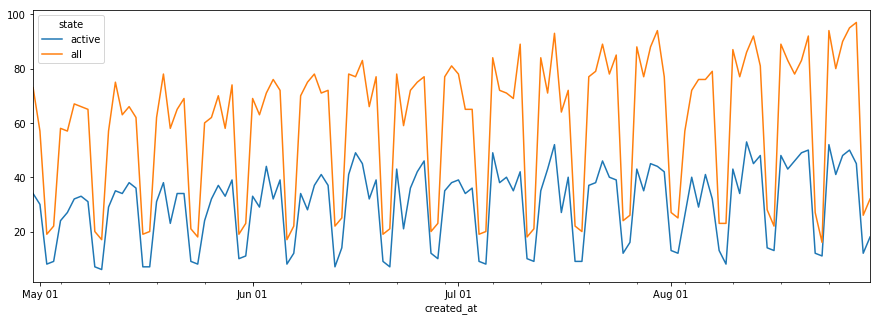

In [3]:
# Counting the number of active/pending for each day
df_signup = df_users.groupby('created_at')['state'].value_counts().unstack()
# Add them to get the total nb of signups
df_signup['all'] = df_signup['active'] + df_signup['pending']
display(df_signup.head())
# PLot the active and all timeseries, keeping only recent data
df_signup[df_signup.index >= pd.to_datetime('2014-5-1')].plot(y=['active', 'all'], figsize=(15,5))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

We can see from this plot that there are no changes (drops) happening during the end of july/early august period. Signups don't seem to be the reason why our service is having issues.

# Looking at existing users

Now I want to find out if some users are using our service less.

In [4]:
# Loading the events
df_events = pd.read_csv('yammer_events.csv')
# Converting date
df_events['occurred_at'] = pd.to_datetime(df_events['occurred_at']).dt.floor('1D')
# Keep only engagements
df_events = df_events[df_events.event_type == 'engagement'].drop('event_type', axis=1)
df_events.head()

,user_id,occurred_at,event_name,location,device,user_type
0,10522.0,2014-05-02,login,Japan,dell inspiron notebook,3.0
1,10522.0,2014-05-02,home_page,Japan,dell inspiron notebook,3.0
2,10522.0,2014-05-02,like_message,Japan,dell inspiron notebook,3.0
3,10522.0,2014-05-02,view_inbox,Japan,dell inspiron notebook,3.0
4,10522.0,2014-05-02,search_run,Japan,dell inspiron notebook,3.0


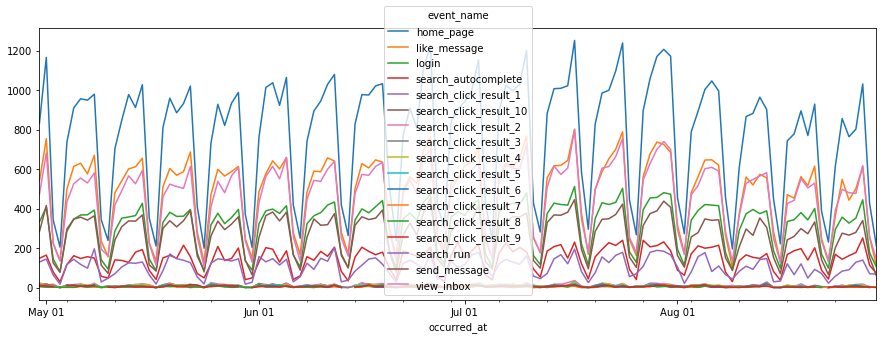

In [5]:
# Finding the nb of event names through time 
df_event_name = df_events.groupby('occurred_at')['event_name'].value_counts().unstack()
df_event_name.plot(figsize=(15,5))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

It seems that all type of engagements have deceased during that period, in particular home page visits.

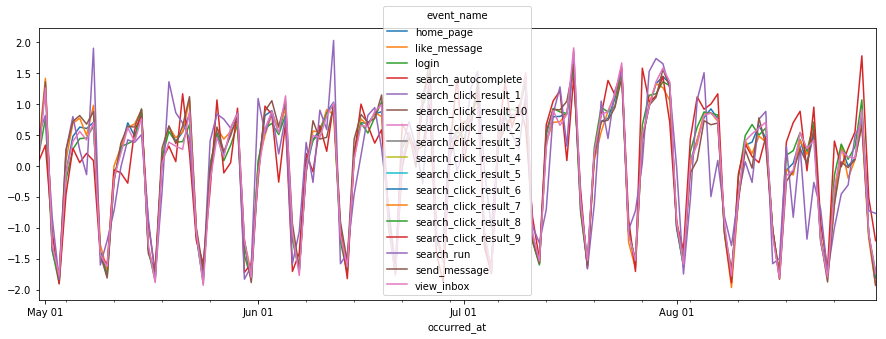

In [6]:
# Plotting the normalized counts to see the relative changes
from scipy.stats import zscore
df_event_name.apply(zscore).plot(figsize=(15,5))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

We see here that the decrease is similar for all engagements. So we can conclude that it is a general effect over all types of engagements.

Now, let's dive into our users. How long have they been registered?

,user_id,created_at,company_id,language,activated_at,state,account_age
0,0.0,2013-01-01,5737.0,english,2013-01-01,active,608
1,1.0,2013-01-01,28.0,english,NaT,pending,608
2,2.0,2013-01-01,51.0,english,NaT,pending,608
3,3.0,2013-01-01,2800.0,german,2013-01-01,active,608
4,4.0,2013-01-01,5110.0,indian,2013-01-01,active,608


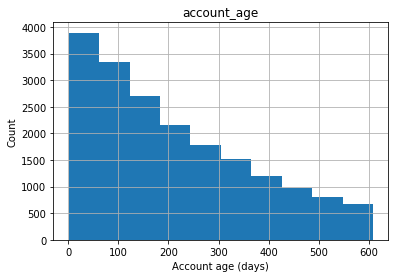

In [7]:
# Measuring how old our users are
df_users['account_age'] = (pd.to_datetime('2014-09-01') - df_users['created_at']).dt.days.astype('int')
display(df_users.head())
df_users.hist(column=['account_age'])
plt.xlabel('Account age (days)')
plt.ylabel('Count');

We can see that because of our growth there is a lot a young accounts. But it would be interesting to see how the account age correlates with the level of engagement. Let's compare the users that were active on july vs. august

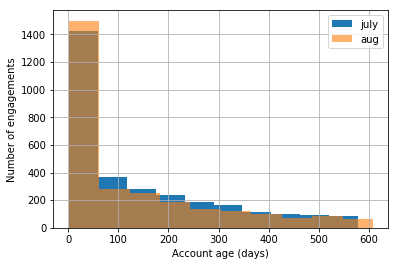

In [8]:
# Find the events in July and August
df_events_july = df_events[(pd.to_datetime('2014-7-1') <= df_events.occurred_at) & (df_events.occurred_at < pd.to_datetime('2014-8-1'))]
df_events_aug = df_events[(pd.to_datetime('2014-8-1') <= df_events.occurred_at) & (df_events.occurred_at < pd.to_datetime('2014-9-1'))]
# Join with the user table to find the age of each user account
df_july = df_users.join(df_events_july.set_index('user_id'), on='user_id', how='inner')
(df_july.groupby('user_id')['account_age'].mean()-30).hist(label='july') # -30 is to correct for age difference
df_aug = df_users.join(df_events_aug.set_index('user_id'), on='user_id', how='inner')
df_aug.groupby('user_id')['account_age'].mean().hist(label='aug', alpha=0.6)
plt.legend()
plt.xlabel('Account age (days)')
plt.ylabel('Number of engagements');

On this plot, we can see that in August there was more young accounts (<50 days) engaged with the website than in july. Reversely, older accounts used the website less. 

# Conclusion

This analysis highlights the fact that the user growth is still healthy and that all type of engagements evolve similarly through time. However, a key finding is that older user account seem to have reduced their engagements in Aug.

We recommend investigating why those older users are reducing their uses through polls, and also setup some email campaigns to describe new features and use cases for our product to re-engage our older users.